In [1]:
import os
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import tensorflow as tf
import keras

# Loading data

In [2]:
#reading train data and generating labels
train_filepath = 'C-NMC_Leukemia/training_data/'
trainpath_array =[]
Y_train = []
all_cells=0
hem_cells=0
for i in ('/all/', '/hem/'):
    for j in range(3):
        dir_path = train_filepath+'fold_'+str(j)+str(i)
        for k in os.listdir(dir_path):
            path= os.path.join(dir_path,k)
            trainpath_array.append(path)
            if i=='/all/':
                Y_train.append(1) #asign 1 for all cells
                all_cells=all_cells+1
            else:
                Y_train.append(0) #asign 0 for hem cells
                hem_cells=hem_cells+1


In [3]:
print('Total number of cancer cells in the train dataset is',all_cells)
print('Total number of normal cells in the train dataset is',hem_cells)

Total number of cancer cells in the train dataset is 7272
Total number of normal cells in the train dataset is 3389


In [4]:
#reading test data 
test_filepath = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'
testpath_array =[]

for k in os.listdir(test_filepath):
    path= os.path.join(test_filepath,k)
    testpath_array.append(path)

print('Total number of cells in the test dataset is',len(testpath_array))

Total number of cells in the test dataset is 2586


In [ ]:
val_df = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

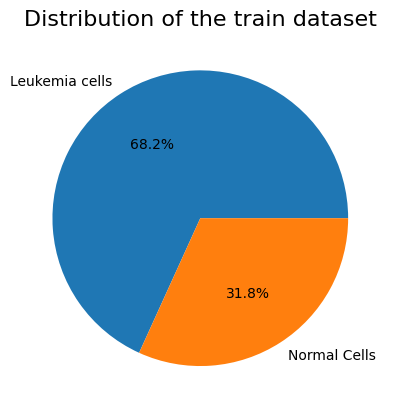

In [5]:
#Display Distribution of the train dataset
plt.pie([all_cells,hem_cells], labels=['Leukemia cells', 'Normal Cells'], autopct='%1.1f%%')
plt.title('Distribution of the train dataset', fontsize=16)
plt.show()

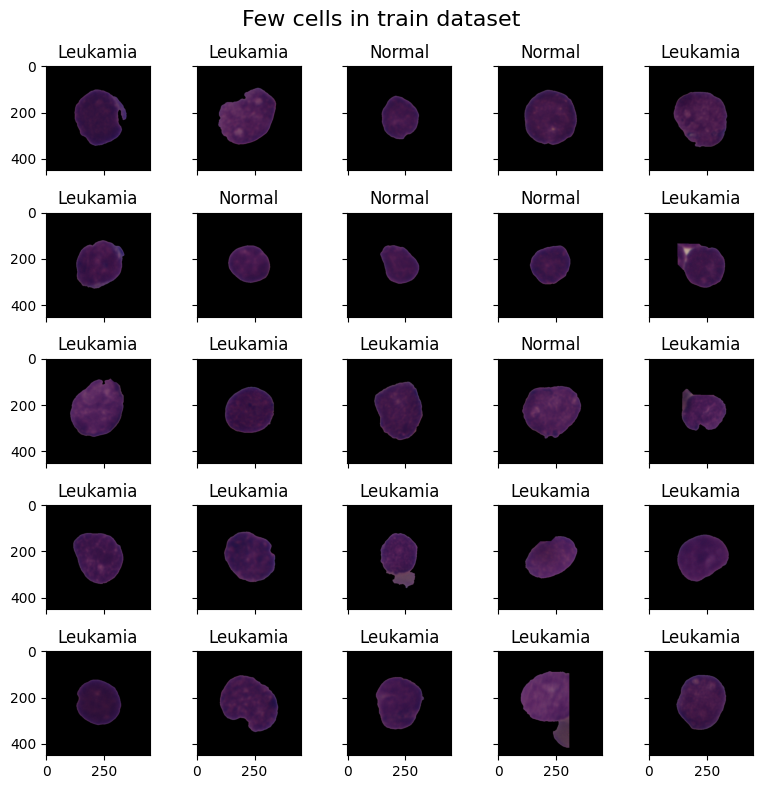

In [6]:
#display random 25 cells in the train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ran = random.randint(0,len(trainpath_array))
    img= io.imread(trainpath_array[ran])
    ax[i].imshow(img)
    if Y_train[ran]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('Few cells in train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
#explore the size of images
img =io.imread(trainpath_array[0])

print('Shape of a cell image', img.shape)

Shape of a cell image (450, 450, 3)


In [8]:
def resize_img(path_array):
    img_width= 128
    img_height= 128
    img_channels= 3

    img_array= np.zeros((len(path_array), img_height, img_width, img_channels), dtype=np.uint8)
    print('Loading resized cell images')
    for i in tqdm(range(len(path_array))):
        img= io.imread(path_array[i])
        #resize the image
        img= resize(img, (img_height, img_width), mode ='constant', preserve_range=True)
        img_array[i]= img
    return img_array

In [9]:
#resized train data
X_train = resize_img(trainpath_array)

Loading resized cell images


100%|████████████████████████████████████████████████████████████████████████████████| 10661/10661 [04:47<00:00, 37.08it/s]


In [10]:
#shuffle data
combined = list(zip(X_train, Y_train))
random.seed(42)
random.shuffle(combined)
X_train, Y_train= zip(*combined)

#convert tuple into arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [11]:
#shape of X_train and Y_train
X_train.shape, Y_train.shape

((10661, 128, 128, 3), (10661,))

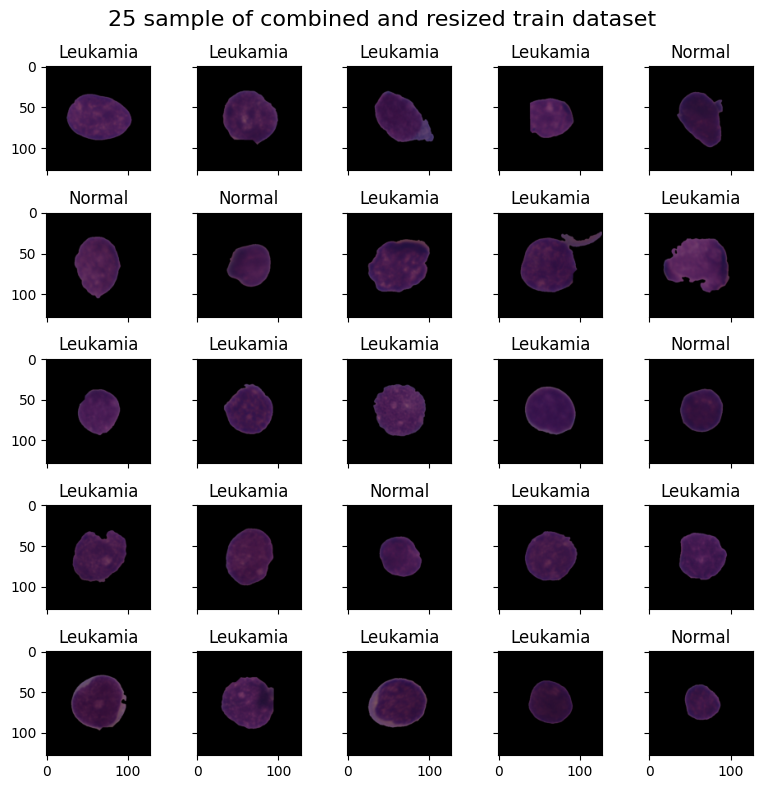

In [12]:
#display resized train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ax[i].imshow(X_train[i])
    if Y_train[i]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('25 sample of combined and resized train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
#resized test data
X_test = resize_img(testpath_array)

Loading resized cell images


100%|██████████████████████████████████████████████████████████████████████████████████| 2586/2586 [01:39<00:00, 25.95it/s]


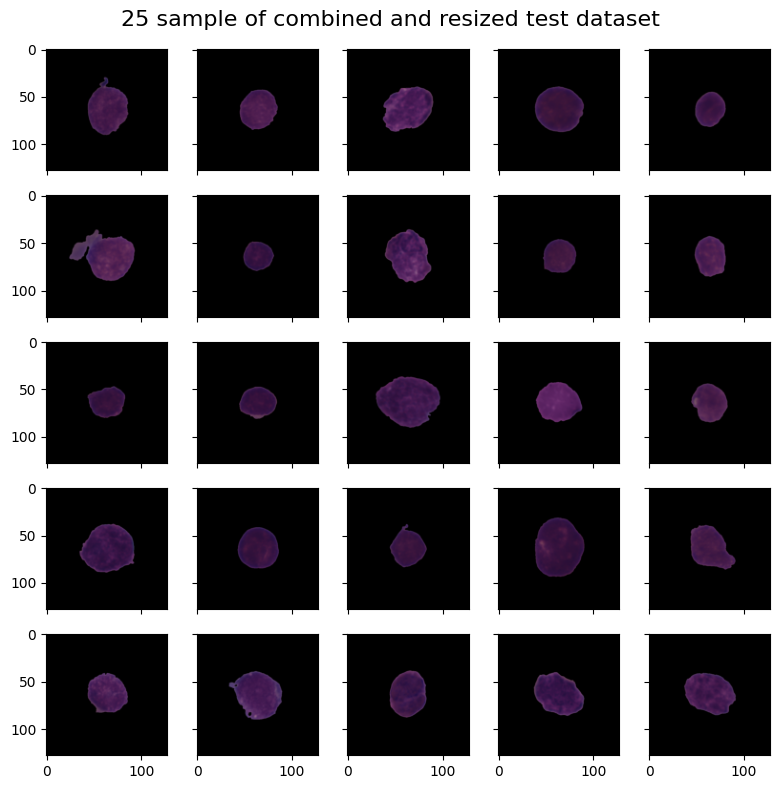

In [14]:
#display resized test dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ax[i].imshow(X_test[i])
fig.suptitle('25 sample of combined and resized test dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [36]:
#build model

img_width= 128
img_height= 128
img_channels= 3

#input layer
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))
#convert pixel values to float because weights in NN are floats
#pixel values are in between 0-255. Therefore divide all pixels from 255
s= tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#contraction path
c1 =tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(s)
c1 =tf.keras.layers.Dropout(0.1)(c1)
c1 =tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c1)
p1 =tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 =tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(p1)
c2 =tf.keras.layers.Dropout(0.1)(c2)
c2 =tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c2)
p2 =tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 =tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(p2)
c3 =tf.keras.layers.Dropout(0.2)(c3)
c3 =tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c3)
p3 =tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 =tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(p3)
c4 =tf.keras.layers.Dropout(0.2)(c4)
c4 =tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c4)
p4 =tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 =tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(p4)
c5 =tf.keras.layers.Dropout(0.3)(c5)
c5 =tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c5)


# Global Average Pooling
g = tf.keras.layers.GlobalAveragePooling2D()(c5)

d1 = tf.keras.layers.Dense(256, activation='relu')(g)
d2 =tf.keras.layers.Dense(1, activation= 'sigmoid')(d1)

model = tf.keras.Model(inputs=[inputs], outputs=[d2])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_126 (Conv2D)                  │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_127 (Conv2D)                  │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_128 (Conv2D)                  │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,244,817 (4.75 MB)

 Trainable params: 1,244,817 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:

#fit the model
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'), checkpointer]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks, shuffle=True)

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6821 - loss: 0.6198
Epoch 1: val_loss improved from inf to 0.49348, saving model to best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.6822 - loss: 0.6197 - val_accuracy: 0.8013 - val_loss: 0.4935
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7912 - loss: 0.4742
Epoch 2: val_loss improved from 0.49348 to 0.47769, saving model to best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 92s 153ms/step - accuracy: 0.7912 - loss: 0.4742 - val_accuracy: 0.8135 - val_loss: 0.4777
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7994 - loss: 0.4594
Epoch 3: val_loss improved from 0.47769 to 0.43501, saving model to best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 92s 153ms/step - accuracy: 0.7994 - loss: 0.4594 - val_accuracy: 0.8182 - val_loss: 0.4350
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8002 - loss: 0.4638
Epoch 4: val_loss did not improve

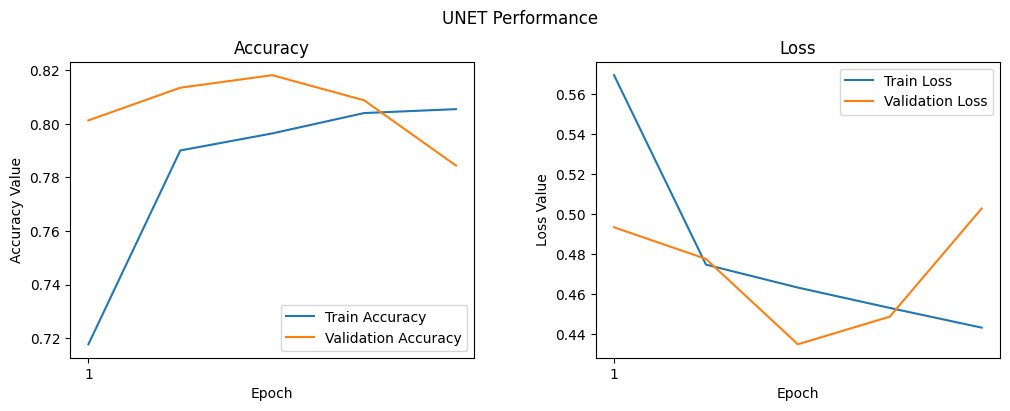

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('UNET Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [43]:
INPUT_SHAPE = (img_width, img_height, img_channels)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)
t= keras.layers.Lambda(lambda x: x/255)(inp)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(t)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(1, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',   
                metrics=['accuracy'])
print(model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_136 (Conv2D)                  │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_137 (Conv2D)                  │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,922,785 (64.56 MB)

 Trainable params: 16,921,121 (64.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

None


In [44]:
#Fit the model
history = model.fit(X_train, Y_train, batch_size = 64, verbose = 1, epochs = 5, validation_split = 0.1,
                         shuffle = False)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 298ms/step - accuracy: 0.7551 - loss: 0.5721 - val_accuracy: 0.3140 - val_loss: 3.5208
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.8339 - loss: 0.4014 - val_accuracy: 0.3140 - val_loss: 2.6098
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 308ms/step - accuracy: 0.8489 - loss: 0.3774 - val_accuracy: 0.3140 - val_loss: 2.5576
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.8632 - loss: 0.3298 - val_accuracy: 0.3271 - val_loss: 1.1791
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.8822 - loss: 0.2950 - val_accuracy: 0.6495 - val_loss: 1.0112


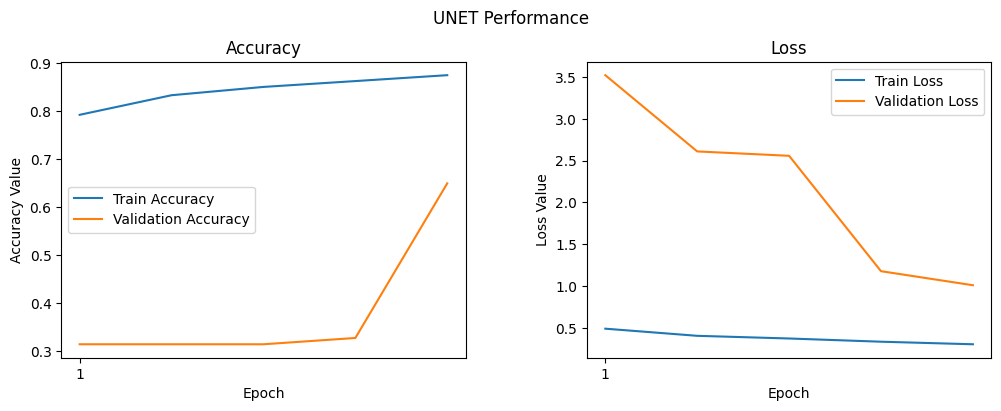

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('UNET Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")